### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
INDEX_TYPE = "SM"

In [2]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts/MxLayerIndex scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [3]:
# from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
import matplotlib.pyplot as plt
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
import dask_labextension
from pathlib import Path
import numpy as np
import dask
from multipledispatch import dispatch
sns.set_context("talk")

### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC2}}{\text{PC1}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [4]:
# Store data (serialize)
indexdir = INDEX_TYPE + "_Phases"
import pickle
with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/Composites.pickle"), 'rb') as handle:
    DJF_phases = pickle.load(handle)
# Store data (serialize)
with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/CompositesPhase4.pickle"), 'rb') as handle:
    DJF_phase4_dict = pickle.load(handle)
# Store data (serialize)
with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/IndexPhases.pickle"), 'rb') as handle:
    phases_dict = pickle.load(handle)

mxtmp_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))

In [5]:
DJF_phases.keys()

dict_keys(['SST', 'Precip', 'TCWV', 'z500', 'IVTE', 'IVTN'])

In [6]:
rmm = pd.read_csv("rMII_index_latest.txt", delim_whitespace=True)
new_rmm = rmm.iloc[:, 3:]
new_rmm["Dates"] = pd.to_datetime(rmm.iloc[:, 0:3].astype("string").apply("-".join, axis=1))
rmm = new_rmm.rename(columns={new_rmm.columns[0]: "PC1", 
                       new_rmm.columns[1]: "PC2",
                       new_rmm.columns[2]: "Phase"})
rmm["Amplitude"] = np.sqrt(rmm["PC1"]**2 + rmm["PC2"]**2)
rmm = rmm.set_index("Dates")

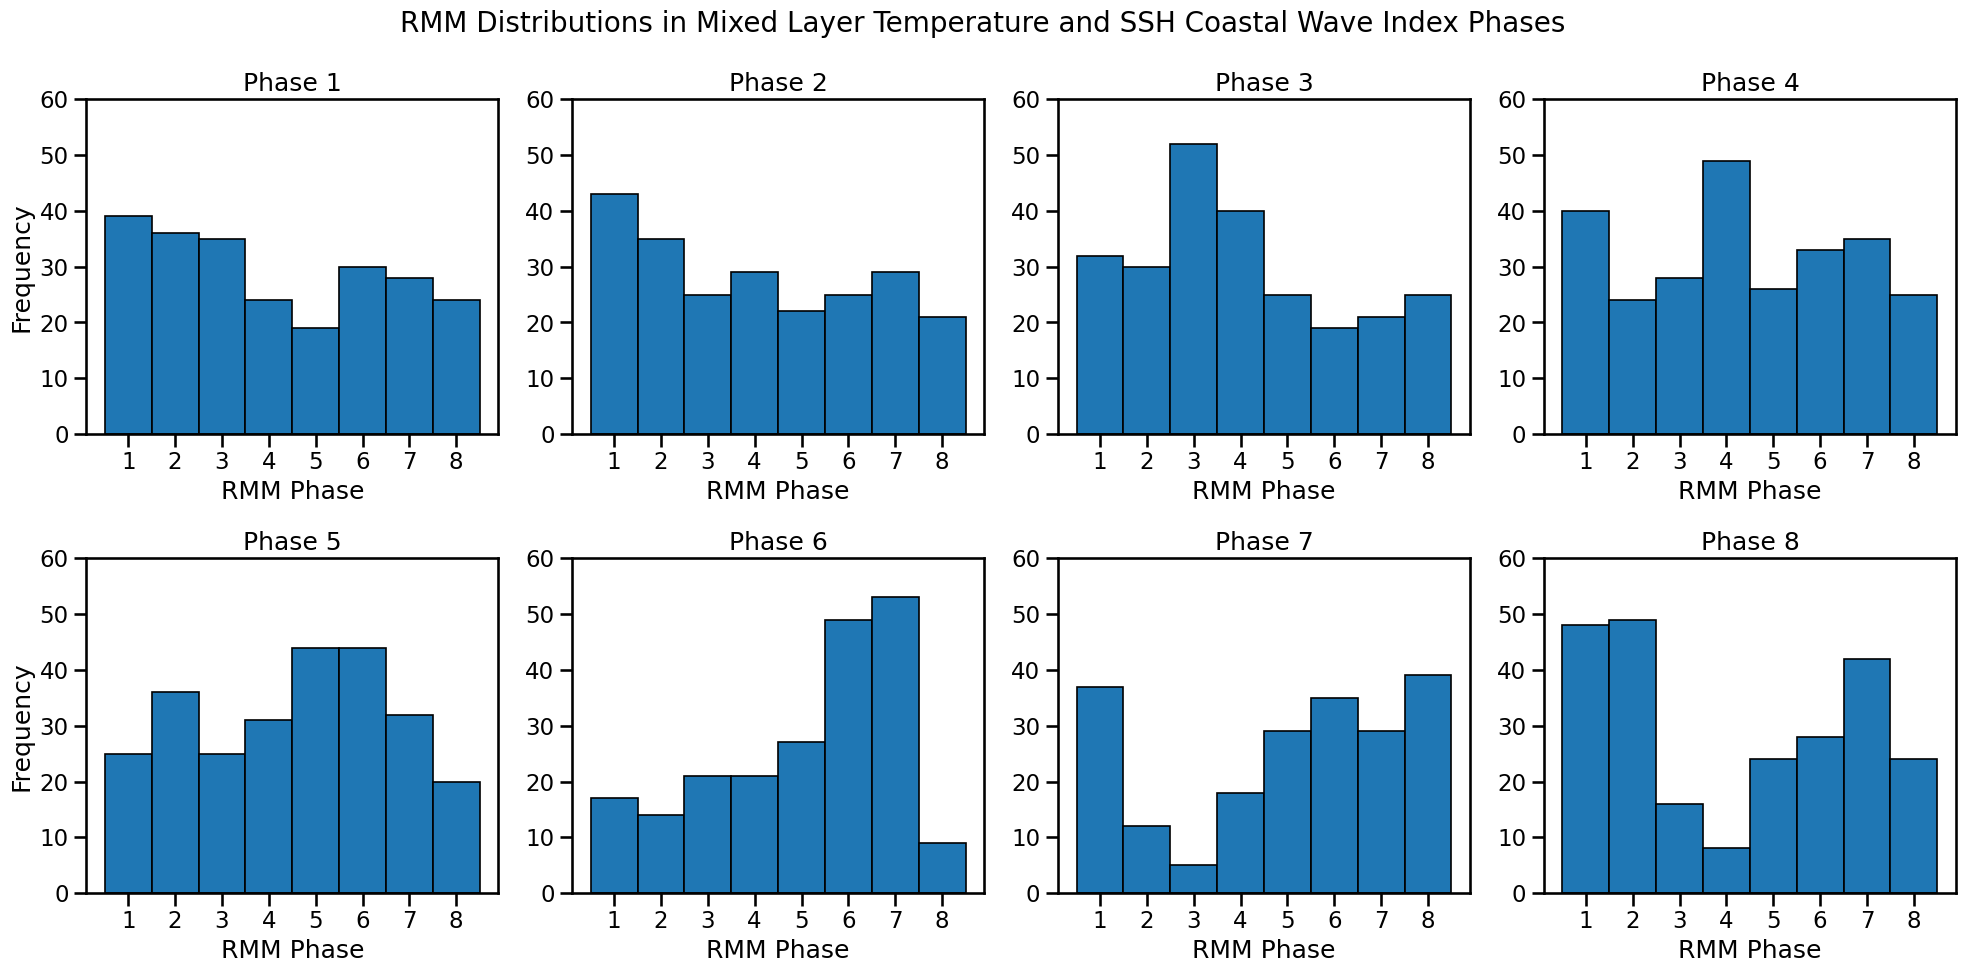

In [7]:
bin_edges = np.arange(0.5, 8.5+1, 1)

fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (20, 10))
fig.suptitle("RMM Distributions in Mixed Layer Temperature and SSH Coastal Wave Index Phases", fontsize = 20)

for phase, indices in phases_dict.items():
    phase_num = int(phase) - 1; i = phase_num
    time_indices = indices.flatten()
    glorys_times = mxtmp_Idx.isel(time = time_indices).time.values
    ax = axes.flatten(order = "C")[phase_num]
    ax.hist(rmm.loc[glorys_times]["Phase"].values, bins = bin_edges, rwidth = 1.0, 
            edgecolor='black', linewidth=1.2)
    ax.set_xticks(np.arange(1, 8+1, 1))
    ax.set_ylim(0, 60)
    ax.set_xlabel("RMM Phase")
    ax.set_title("Phase " + phase)
[ax.set_ylabel("Frequency") for ax in axes[:, 0]]
fig.tight_layout()

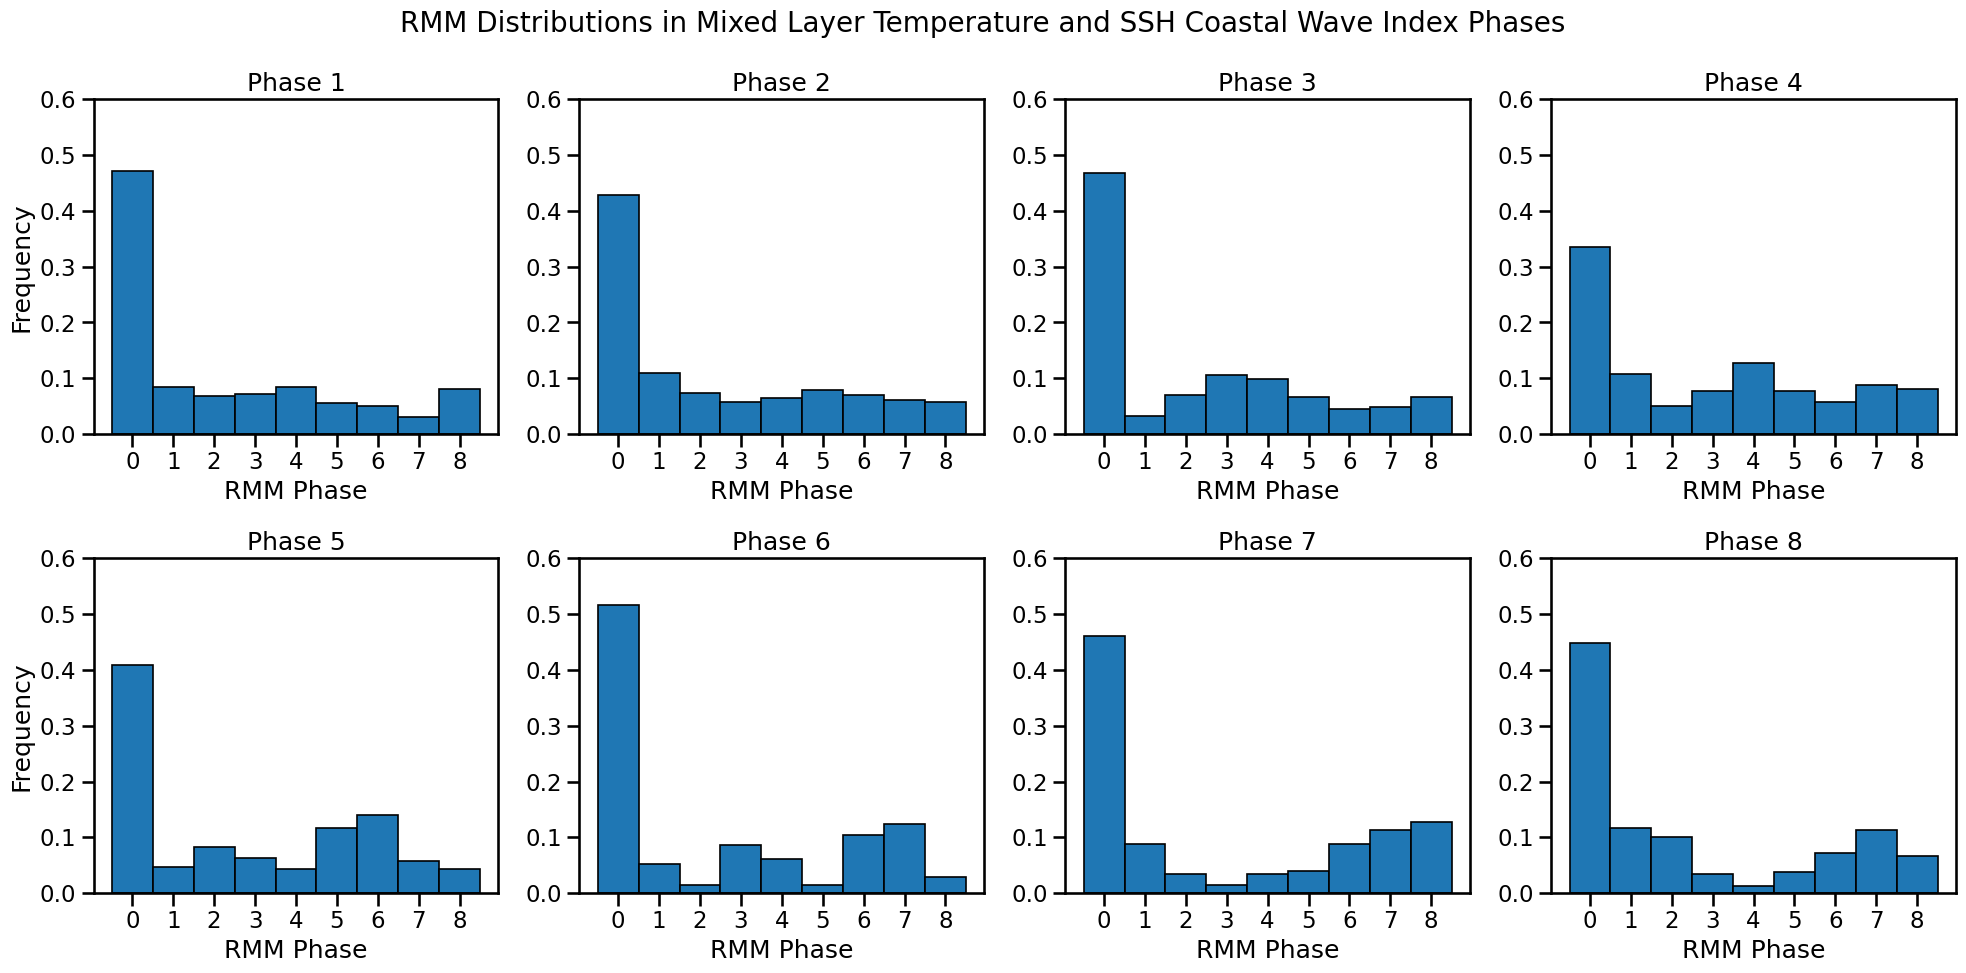

In [8]:
bin_edges = np.arange(-0.5, 8.5+1, 1)

fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (20, 10))
fig.suptitle("RMM Distributions in Mixed Layer Temperature and SSH Coastal Wave Index Phases", fontsize = 20)

for phase, indices in phases_dict.items():
    phase_num = int(phase) - 1; i = phase_num
    time_indices = indices.flatten()
    glorys_times = mxtmp_Idx.isel(time = time_indices).time.values
    values = rmm.loc[glorys_times]
    values.loc[values["Amplitude"] < 1, ["Phase"]] = 0
    ax = axes.flatten(order = "C")[phase_num]
    ax.hist(values["Phase"].values, bins = bin_edges, rwidth = 1, density = True,
            edgecolor='black', linewidth=1.2)
    ax.set_xticks(np.arange(0, 8+1, 1))
    ax.set_ylim(0, 0.6)
    ax.set_xlabel("RMM Phase")
    ax.set_title("Phase " + phase)
[ax.set_ylabel("Frequency") for ax in axes[:, 0]]
fig.tight_layout()